In [17]:
import numpy as np
np.random.seed(1)
import matplotlib.pyplot as plt
import pandas as pd

!pip install colorednoise

In [18]:
fs = 1000  # 1 kHz
total_time = 10000  # 10 seconds or 10000 milliseconds

samples = 1 * total_time
t = np.linspace(0, total_time/1000, samples)

In [19]:
import colorednoise as cn

beta = 1  # pink noise is 1

noise = cn.powerlaw_psd_gaussian(beta, samples)
print(noise.shape)

(10000,)


In [20]:
from scipy import signal

noise_amp = abs(signal.hilbert(noise))
threshold = np.mean(noise_amp) + (2 * np.std(noise_amp))

2.5713611807897294


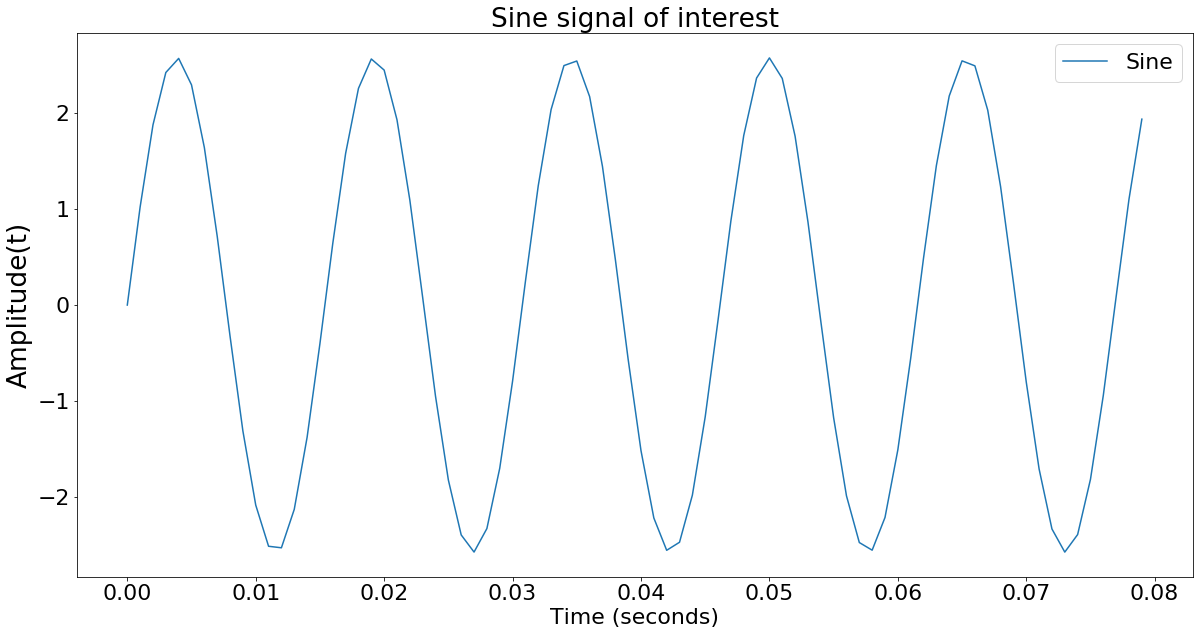

In [21]:
amplitude = threshold
print(amplitude)
frequency = 65  # 65 Hz

sine = amplitude * np.sin(frequency * 2 * np.pi * t)
plt.plot(t[:80], sine[:80], label='Sine')
plt.title('Sine signal of interest')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude(t)', fontsize='large')
# plt.xlim(1,samples)
plt.legend()
plt.show()

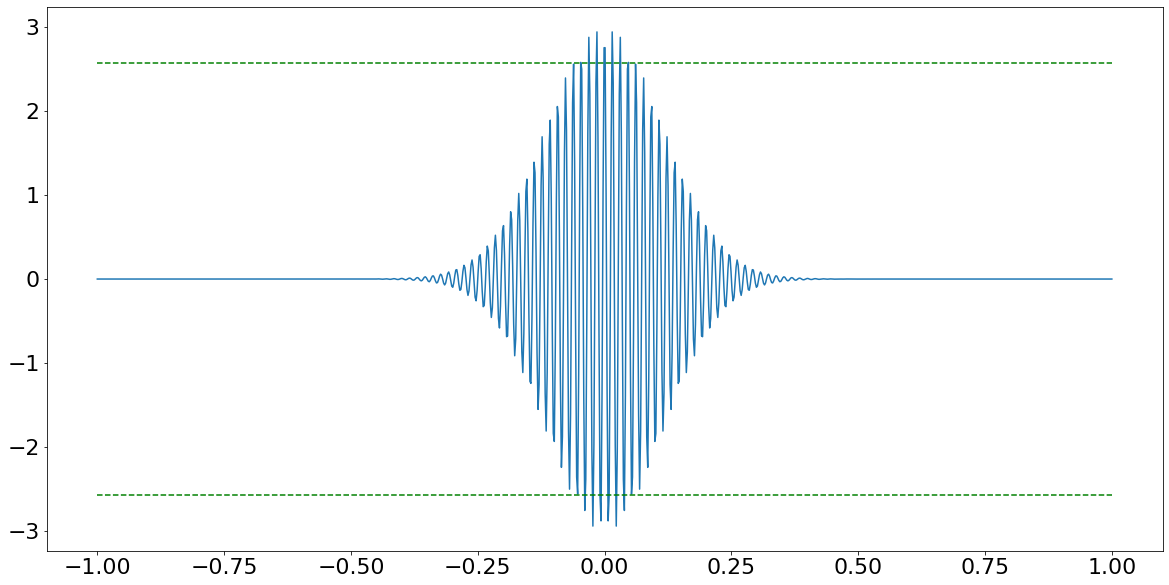

In [40]:
gp_t = np.linspace(-1, 1, 1000)

yl = signal.gausspulse(gp_t, fc=65, bw=0.05)
plt.plot(gp_t, yl * 3)
plt.plot(gp_t, [threshold for _ in range(gp_t.shape[0])], 'g--')
plt.plot(gp_t, [-threshold for _ in range(gp_t.shape[0])], 'g--')
plt.show()

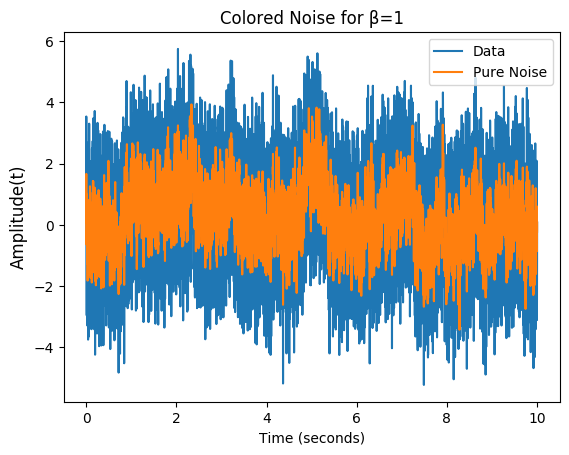

In [6]:
plt.plot(t, noise+sine, label='Data')
plt.plot(t, noise, label='Pure Noise')
plt.title('Colored Noise for β='+str(beta))
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude(t)', fontsize='large')
plt.legend()
plt.show()

In [7]:
sin_len = 400

z, a = signal.butter(4, [55, 85], btype='bandpass', output='ba', fs=fs)
filtered_data = signal.filtfilt(z, a, noise + sine, axis=0)

data = []
labels = []
num_samples = 7500
indices = np.random.choice(noise.shape[0] - sin_len, num_samples, replace=False)
inc_sin = np.random.choice([1], size=num_samples, replace=True)
for i, idx in enumerate(indices):
    if inc_sin[i] == 1:
        data.append(noise[idx:idx+int(sin_len/2)] + sine[idx:idx+int(sin_len/2)])
        # data.append(sine[idx:idx+200])
        # labels.append(noise[idx+200:idx+400] + sine[idx:idx+200])
        labels.append(sine[idx+200:idx+400])
        # labels.append(filtered_data[idx+int(sin_len/2):idx+sin_len])
    else:
        data.append(noise[idx:idx+int(sin_len/2)])
        labels.append(np.zeros(int(sin_len/2)))



data = np.stack(data).reshape((num_samples, 1, -1))
labels = np.stack(labels).reshape((num_samples, 1, -1))
print(data.shape)
print(labels.shape)

(7500, 1, 200)
(7500, 1, 200)


In [8]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

split_idx = int(.75 * data.shape[0])

print(split_idx)
print(data.shape)
print(labels.shape)

train_data = DataLoader(TensorDataset(torch.Tensor(data[:split_idx, :, :]), torch.Tensor(labels[:split_idx, :, :])), batch_size=batch_size, shuffle=True)
valid_data = DataLoader(TensorDataset(torch.Tensor(data[split_idx:, :, :]), torch.Tensor(labels[split_idx:, :, :])), batch_size=batch_size, shuffle=False)

5625
(7500, 1, 200)
(7500, 1, 200)


<Figure size 1000x1000 with 0 Axes>

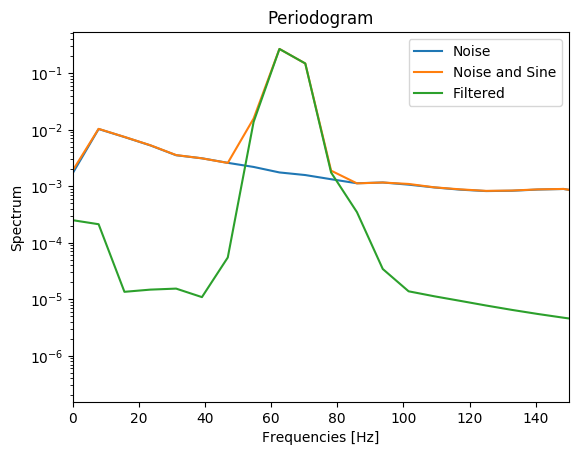

In [9]:
from scipy.signal import welch

plt.figure(figsize=(10, 10))

axs = plt.subplots()

f_n, psd_n = welch(noise, fs=fs, window='hamming', nperseg=128, scaling='density', axis=0)
f_ns, psd_ns = welch(noise+sine, fs=fs, window='hamming', nperseg=128, scaling='density', axis=0)
f_f, psd_f = welch(filtered_data, fs=fs, window='hamming', nperseg=128, scaling='density', axis=0)
plt.semilogy(f_n, psd_n, label='Noise')
plt.semilogy(f_ns, psd_ns, label='Noise and Sine')
plt.semilogy(f_f, psd_f, label='Filtered')
# plt.ylim([1e-3, 1e-1])
plt.xlim([0, 150])
plt.xlabel('Frequencies [Hz]')
plt.ylabel('Spectrum')
plt.title('Periodogram')
plt.legend()
plt.show()

In [10]:
import torch
import torch.nn as nn

class FullyConnected(nn.Module):
    def __init__(self,
                 in_size: int = 200,
                 out_size: int = 200):
        super(FullyConnected, self).__init__()
        self.fcn = nn.Sequential(
            nn.Linear(in_size, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, 200)
        )

    def forward(self, x):
        return self.fcn(x)


class LSTM(nn.Module):
    def __init__(self, in_size: int = 1,
                 h_size: int = 200,
                 out_size: int = 200,
                 num_layers: int = 1,
                 batch_first: bool = True,
                 dropout: float = 0.0) -> None:
        super(LSTM, self).__init__()
        self.rnn = nn.LSTM(input_size=in_size,
                           hidden_size=h_size,
                           num_layers=num_layers,
                           batch_first=batch_first,
                           dropout=dropout)
        self.lin = nn.Linear(h_size, out_size)

    def forward(self, x):
        x = torch.transpose(x, 1, 2)  # RNN variants expect (N, L, H)
        x, (_, _) = self.rnn(x)  # Returns (N, L, hidden_size)
        return x[:, -1, :]
        # out = self.lin(x[:, -1, :])  # Feeds hidden stats of last cell to FCN
        # return out

In [11]:
from typing import Optional, Tuple, List
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm


def fit(model: nn.Module,
        training_loader: DataLoader,
        validation_loader: DataLoader,
        epochs: int = 50,
        device: str = 'cpu',
        write_losses: bool = False,
        save_filepath: Optional[str] = None,
        **kwargs) -> Tuple[List, List]:
    """
    Function used to fit the specified model with the provided data
    :param model: neural network pytorch model
    :param training_loader: pytorch dataloader containing the training data
    :param validation_loader: pytorch dataloader containing the validation data
    :param epochs: number of epochs to train
    :param device: which device to train the model on. Should be either "cuda:0" or "cpu"
    :param write_losses: boolean flag as to report losses during training
    :param save_filepath: path to save model, if not specified, no model is saved
    :param kwargs: "optim" optimizer,
                    "loss_function" loss function,
                    "decay_rate" decay rate,
                    "model_save_path" model save path,
                    "loss_save_path" csv save path
    :return: training and validation losses over each epoch
    """
    train_loss_list = []
    val_loss_list = []

    # splitting the dataloaders to generalize code
    data_loaders = {"train": training_loader, "val": validation_loader}
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) if 'optim' not in kwargs else kwargs.get('optim')

    loss_func = nn.MSELoss() if 'loss_function' not in kwargs else kwargs.get('loss_function')

    decay_rate = .99995 if 'decay_rate' not in kwargs else kwargs.get('decay_rate')
    lr_sch = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)

    temp_loss = 100000000000000.0

    """
    You can easily adjust the number of epochs trained here by changing the number in the range
    """
    for epoch in tqdm(range(epochs), position=0, leave=True):
        train_loss = 0.0
        val_loss = 0.0

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            for i, (x, y) in enumerate(data_loaders[phase]):
                x = x.to(device)
                output = model(x)
                y = y.to(device)
                loss = loss_func(torch.squeeze(output), torch.squeeze(y))

                # backprop
                optimizer.zero_grad()
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # calculating total loss
                running_loss += loss.item()

            if phase == 'train':
                train_loss = running_loss
                lr_sch.step()
            else:
                val_loss = running_loss

        # shows total loss
        if epoch % 10 == 0 and write_losses:
            tqdm.write('{} train loss: {.6f} val loss: {.6f}'.format(epoch + 1, train_loss, val_loss))

        # saving best model
        if train_loss < temp_loss and save_filepath:
            torch.save(model, save_filepath)
            temp_loss = train_loss

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)


    return train_loss_list, val_loss_list

In [12]:
import copy

epochs = 50
# model = LSTM()
model = FullyConnected()
model_initial = copy.deepcopy(model)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
t_loss, v_loss = fit(model, train_data, valid_data, epochs, device)

  0%|          | 0/50 [00:00<?, ?it/s]

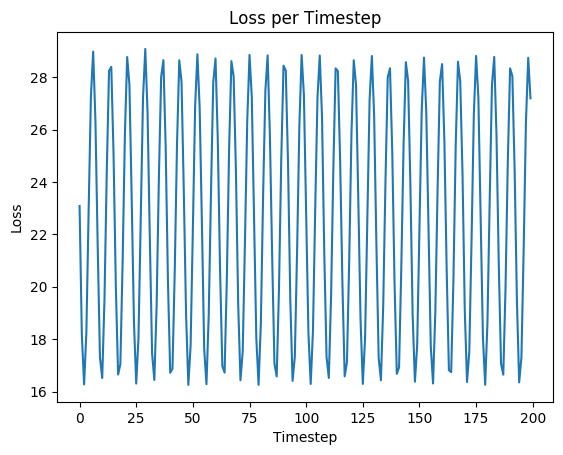

In [13]:
def validate_model(model: nn.Module,
                   validation_loader: torch.utils.data.DataLoader,
                   device: torch.device) -> Tuple[List[float], List[float]]:
    losses = {i:0 for i in range(0, labels.shape[2], 1)}
    for i, (x, y) in enumerate(validation_loader):
        x = x.to(device)
        output = model(x)
        output = output.to("cpu").detach().numpy()
        y = y.to("cpu").detach().numpy()
        for t in range(0, labels.shape[2], 1):
            y_true = y[:,:,t]
            y_pred = output[:,:,t]
            squared_error = ((y_true - y_pred) ** 2)
            # print(squared_error.shape)
            losses[t] += np.sum(squared_error)
    #  TODO Losses normalized by std of each timestep
    return losses


losses = validate_model(model, valid_data, device)

lists = sorted(losses.items())
timestep, loss_val = zip(*lists)
plt.plot(timestep, loss_val)
plt.xlabel('Timestep')
plt.ylabel('Loss')
plt.title('Loss per Timestep')

plt.show()

In [14]:
x, y = next(iter(valid_data))
model.eval()
x = x.to(device)
output = model(x)
x = x.to("cpu").detach().numpy()
output = output.to("cpu").detach().numpy()
y = y.to("cpu").detach().numpy()

print(x.shape)
print(y.shape)
print(output.shape)

(32, 1, 200)
(32, 1, 200)
(32, 1, 200)


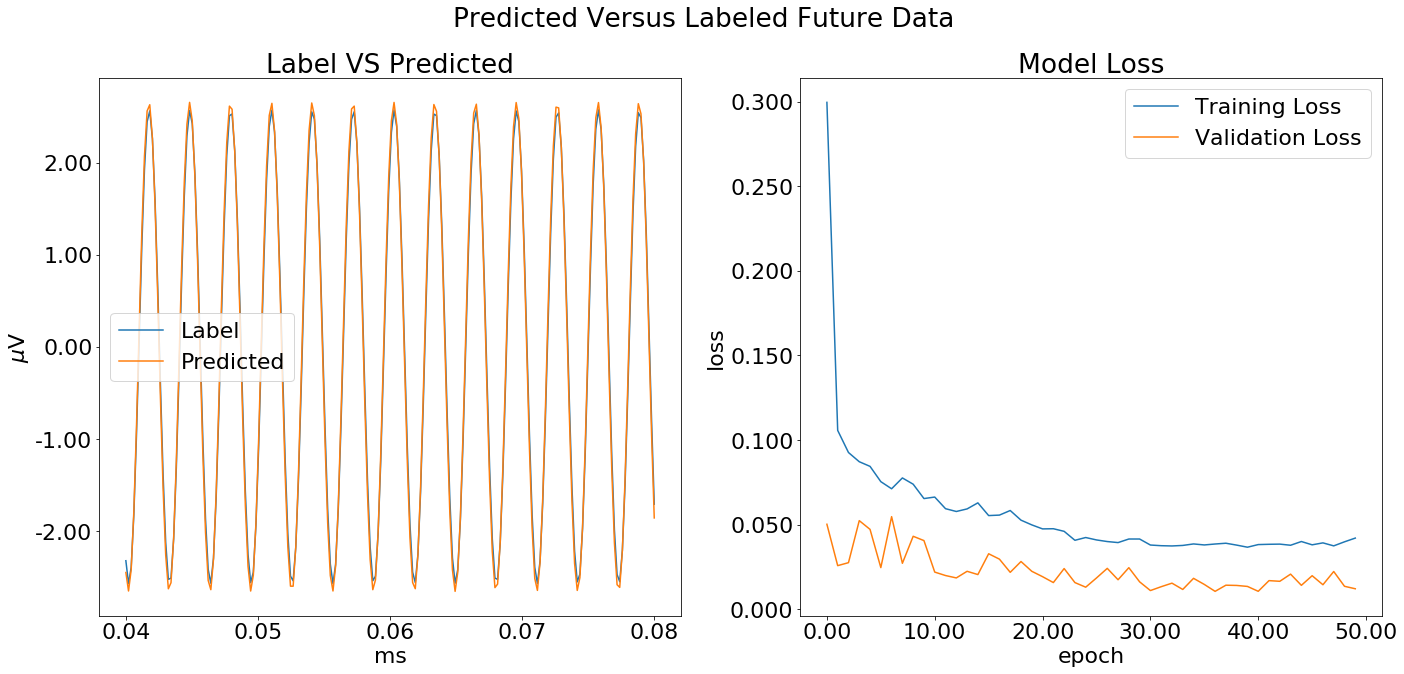

In [15]:
from matplotlib.gridspec import GridSpec
%matplotlib inline
from matplotlib.ticker import FormatStrFormatter

scaled_t_loss = [l/(split_idx/batch_size) for l in t_loss]
scaled_v_loss = [l/((data.shape[0] - split_idx)/batch_size) for l in v_loss]

plt.rcParams['font.size'] = 22

fig = plt.figure(figsize=(20,10))
gs = GridSpec(1,2)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

fig.suptitle('Predicted Versus Labeled Future Data')

t = np.linspace(0.04, 0.08, 200)

ax1.plot(t, y[0,0,:], label='Label')
ax1.plot(t, output[0,0,:], label='Predicted')
ax1.set_xlabel('ms')
ax1.set_ylabel(r'$\mu$V')
ax1.set_title('Label VS Predicted')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.legend(loc='best')

ax2.plot(np.arange(epochs), np.array(scaled_t_loss), label='Training Loss')
ax2.plot(np.arange(epochs), np.array(scaled_v_loss), label='Validation Loss')
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Model Loss')
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.legend(loc='best')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

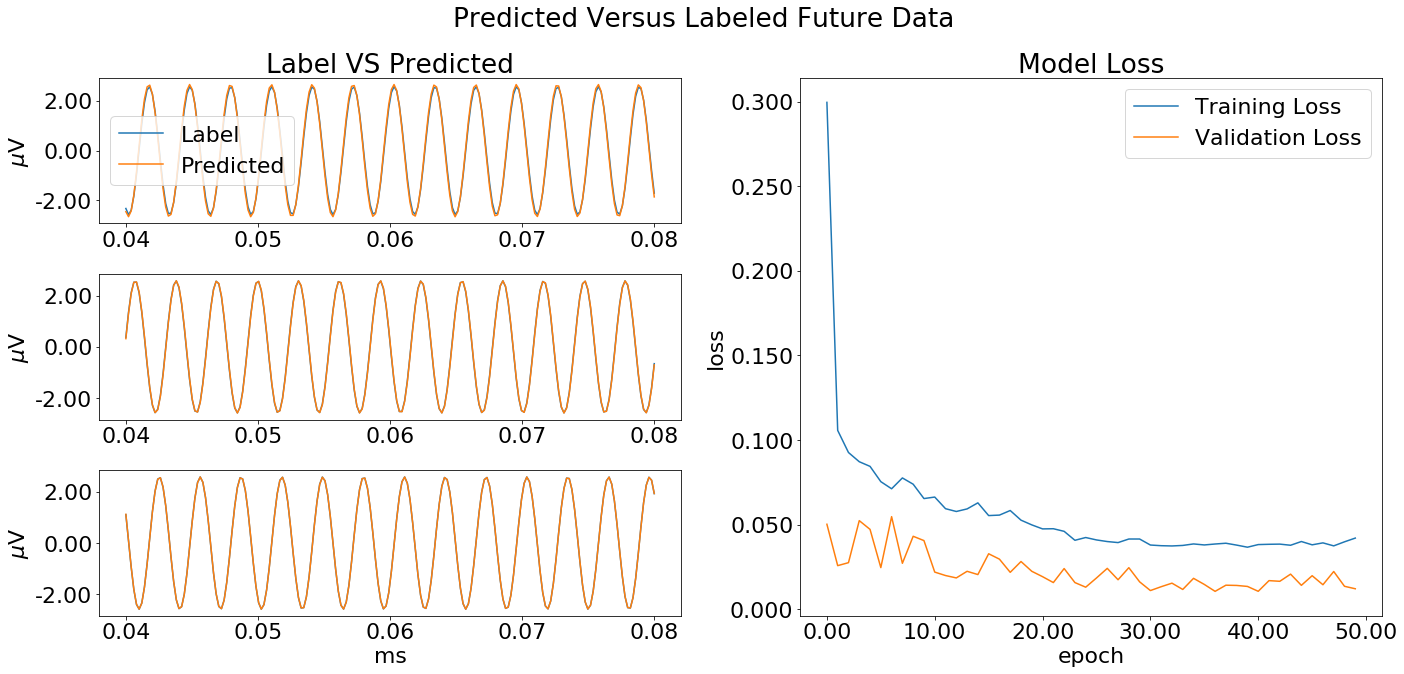

In [16]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 22

fig = plt.figure(figsize=(20,10))
gs = GridSpec(3,2)

ax1 = fig.add_subplot(gs[0,0])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[2,0])
ax2 = fig.add_subplot(gs[:,1])

fig.suptitle('Predicted Versus Labeled Future Data')

t = np.linspace(0.04, 0.08, 200)

ax1.plot(t, y[0,0,:], label='Label')
ax1.plot(t, output[0,0,:], label='Predicted')
ax1.set_ylabel(r'$\mu$V')
ax1.set_title('Label VS Predicted')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.legend(loc='best')

ax3.plot(t, y[1,0,:], label='Label')
ax3.plot(t, output[1,0,:], label='Predicted')
ax3.set_ylabel(r'$\mu$V')
ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax3.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax4.plot(t, y[2,0,:], label='Label')
ax4.plot(t, output[2,0,:], label='Predicted')
ax4.set_xlabel('ms')
ax4.set_ylabel(r'$\mu$V')
ax4.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax4.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax2.plot(np.arange(epochs), np.array(scaled_t_loss), label='Training Loss')
ax2.plot(np.arange(epochs), np.array(scaled_v_loss), label='Validation Loss')
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Model Loss')
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.legend(loc='best')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()